In [131]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import holidays
import seaborn as sns
import matplotlib.pyplot as plt


In [132]:
# Load the Excel file and the relevant sheets

file_path = 'Assessment Data2.csv' 

In [133]:
# read data from csv file

df = pd.read_csv(file_path)

Section One: Look at Daily Time Series for Line Items and Daily Quantity Sold

In [134]:
# Change object to datetime

df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')

In [135]:
# Look at total N/A values in each column

for column in df.columns:
    na_count = df[column].isna().sum()
    print(f"The total number of NaN values in the '{column}' column is: {na_count}")

The total number of NaN values in the 'Order_ID' column is: 0
The total number of NaN values in the 'Order_Date' column is: 5598
The total number of NaN values in the 'Product_ID' column is: 0
The total number of NaN values in the 'Quantity' column is: 0


In [136]:
# Aggregate daily line items and daily quantity sold

df = df.groupby('Order_Date').agg({
    'Order_ID': 'nunique',
    'Quantity': 'sum'
}).reset_index()

In [137]:
# Rename columns for clarity

df.columns = ['Date', 'Daily_Line_Items', 'Daily_Quantity_Sold']

In [138]:
df_copy = df.copy()

In [139]:
# Add a new column 'Holiday'

us_holidays = holidays.US()
df_copy['Holiday'] = df_copy['Date'].apply(lambda x: 1 if x in us_holidays else 0)

In [140]:
# Extract year and create a new column for daily data

df_copy.set_index('Date', inplace=True)
df_copy['Year'] = df_copy.index.year
df_copy['Day'] = df_copy.index.date

In [141]:
# Aggregate by day and year

daily_quantity = df_copy.groupby(['Year', 'Day'])[['Daily_Line_Items', 'Daily_Quantity_Sold']].sum().reset_index()

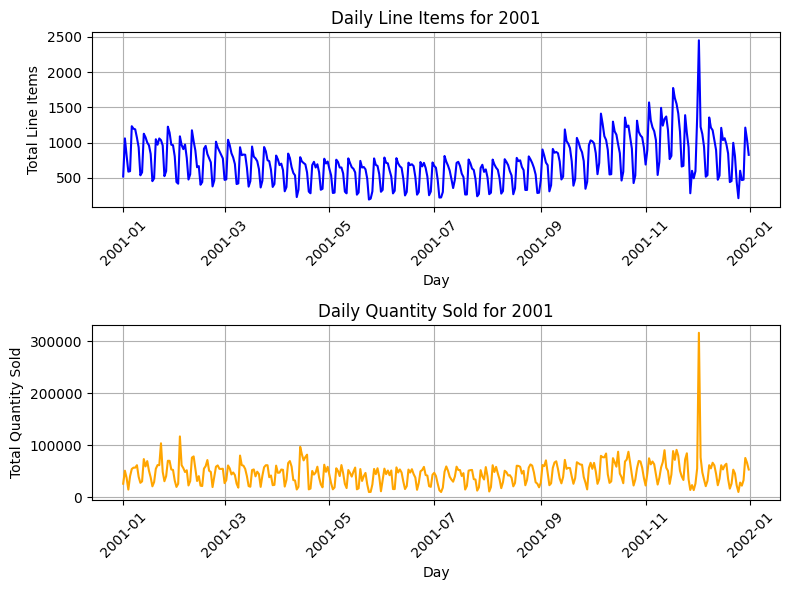

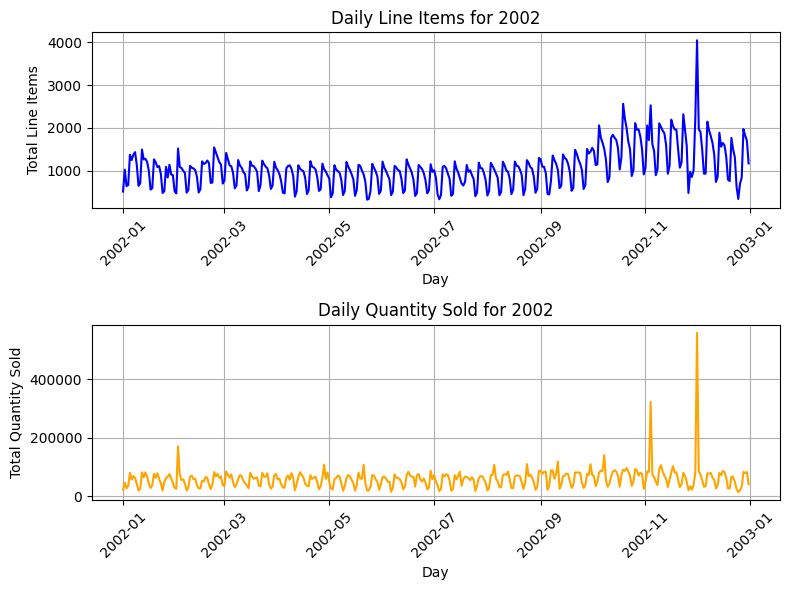

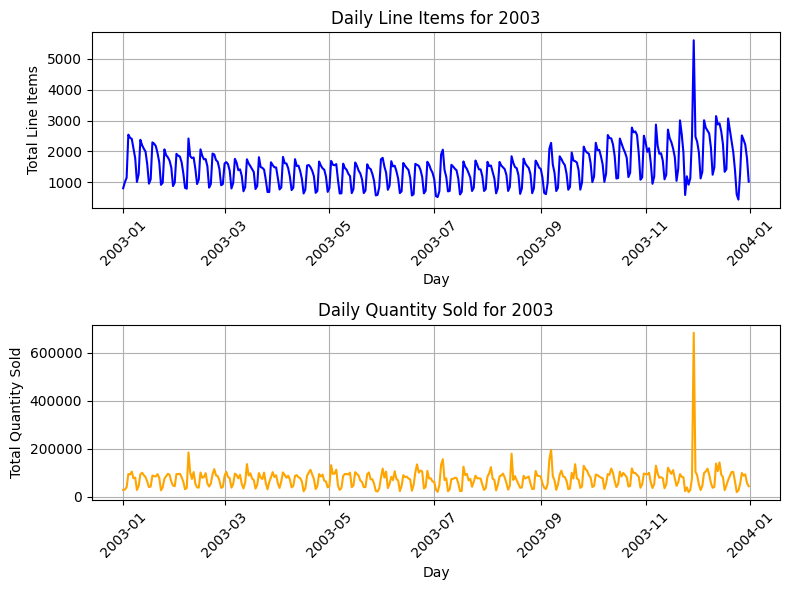

In [142]:
# Create Graphs for daily line items and daily quantity sold for each year


years = daily_quantity['Year'].unique()
for year in years:
    year_data = daily_quantity[daily_quantity['Year'] == year]
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))
    sns.lineplot(data=year_data, x='Day', y='Daily_Line_Items', ax=axs[0], color='blue')
    axs[0].set_title(f'Daily Line Items for {year}')
    axs[0].set_xlabel('Day')
    axs[0].set_ylabel('Total Line Items')
    axs[0].grid(True)
    axs[0].tick_params(axis='x', rotation=45)
    sns.lineplot(data=year_data, x='Day', y='Daily_Quantity_Sold', ax=axs[1], color='orange')
    axs[1].set_title(f'Daily Quantity Sold for {year}')
    axs[1].set_xlabel('Day')
    axs[1].set_ylabel('Total Quantity Sold')
    axs[1].grid(True)
    axs[1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

Section Two: Look at Outliers

In [143]:
# Load the Excel file and the relevant sheets

file_path = 'Assessment Data2.csv' 

In [144]:
df_copy = pd.read_csv(file_path)

In [145]:
# Look at top 5 rows

df_copy.head()

,Order_ID,Order_Date,Product_ID,Quantity
0,Order 12711,2001-01-15 10:43:20,FC40R1003,10
1,Order 12754,2001-01-15 11:15:00,WEL11A-601R,2
2,Order 12874,2001-01-15 12:47:33,34K77,2
3,Order 13036,2001-01-15 14:56:04,V88J1006,2
4,Order 13036,2001-01-15 14:56:04,V8943N1013,2


In [146]:
df_copy

,Order_ID,Order_Date,Product_ID,Quantity
0,Order 12711,2001-01-15 10:43:20,FC40R1003,10
1,Order 12754,2001-01-15 11:15:00,WEL11A-601R,2
2,Order 12874,2001-01-15 12:47:33,34K77,2
3,Order 13036,2001-01-15 14:56:04,V88J1006,2
4,Order 13036,2001-01-15 14:56:04,V8943N1013,2
...,...,...,...,...
3632360,Order 12600,2001-01-15 09:16:35,050-300-OXY,4
3632361,Order 12592,2001-01-15 08:59:22,ST9103A1002,2
3632362,Order 12597,2001-01-15 09:08:47,Z100T2-2,2
3632363,Order 12597,2001-01-15 09:08:47,ZA024Q4A1,2


In [147]:
# Group data by 'Order_ID' and 'Product_ID', and sum the 'Quantity'

grouped_data = df_copy.groupby(['Order_ID', 'Product_ID'])['Quantity'].sum().reset_index()

In [148]:
# Create a unique 'Line_Item' identifier

grouped_data['Line_Item'] = grouped_data['Order_ID'].astype(str) + "_" + grouped_data['Product_ID'].astype(str)

In [149]:
# Rearrange columns for clarity

grouped_data = grouped_data[['Line_Item', 'Order_ID', 'Product_ID', 'Quantity']]

In [150]:
# Create US holiday calendar

cal = calendar()
holidays = cal.holidays(start=df_copy['Order_Date'].min(), end=df_copy['Order_Date'].max())

In [151]:
# Convert 'Order_Date' to datetime

df_copy['Order_Date'] = pd.to_datetime(df_copy['Order_Date'], errors='coerce')

In [152]:
# Add 'Holiday_Flag' column indicating if the date is a US holiday

df_copy['Holiday_Flag'] = df_copy['Order_Date'].isin(holidays).astype(int)

In [153]:
# calculate the IQR

Q1 = df_copy['Quantity'].quantile(0.25)
Q3 = df_copy['Quantity'].quantile(0.75)
IQR = Q3 - Q1


In [154]:
# Define lower and upper bounds for outliers

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


In [155]:
# Identify outliers

outliers = df_copy[(df_copy['Quantity'] < lower_bound) | (df_copy['Quantity'] > upper_bound)]

In [156]:
# Look at outlier summary

outliers_summary = outliers.groupby(['Holiday_Flag', 'Product_ID']).agg({
    'Quantity': ['count', 'mean', 'sum']
}).reset_index()


In [157]:
outliers_summary 

Holiday_Flag    Product_ID Quantity                 
                                    count        mean  sum
0                0  000-0814-008        1   28.000000   28
1                0       0004640        1  144.000000  144
2                0       0004650        1   30.000000   30
3                0     0007-1644        1   48.000000   48
4                0       0009257        2   40.000000   80
...            ...           ...      ...         ...  ...
12753            0        ZG-X40        1   80.000000   80
12754            0      ZVC404-4        3   33.333333  100
12755            0      ZVC405-4        2   30.000000   60
12756            0      ZVC406-4        1   40.000000   40
12757            0     eBAR464X5        3   48.000000  144

[12758 rows x 5 columns]

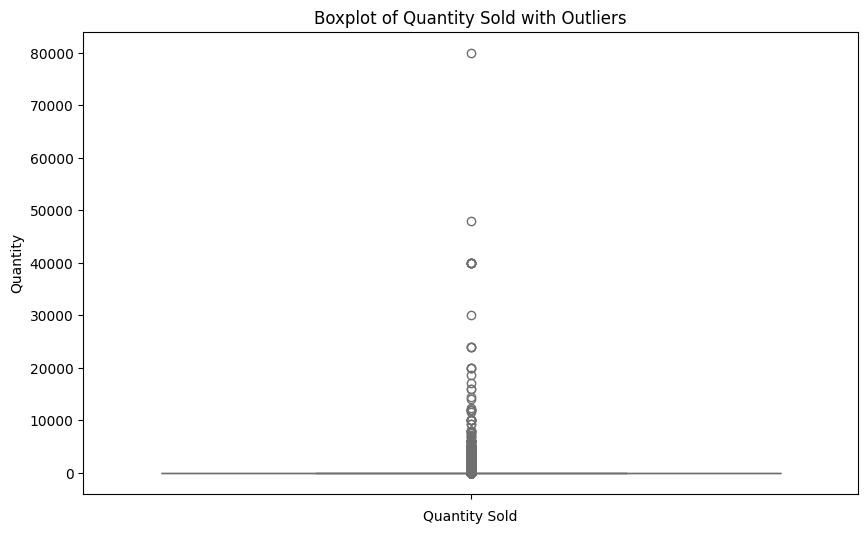

In [158]:
# Visualize the distribution of 'Quantity'

plt.figure(figsize=(10, 6))
sns.boxplot(df_copy['Quantity'], color='skyblue')
plt.title('Boxplot of Quantity Sold with Outliers')
plt.xlabel('Quantity Sold')
plt.show()

In [159]:
# Determine how many of the records are inliers vs outliers

inliers = df_copy[(df_copy['Quantity'] >= lower_bound) & (df_copy['Quantity'] <= upper_bound)]
outliers = df_copy[(df_copy['Quantity'] < lower_bound) | (df_copy['Quantity'] > upper_bound)]

In [160]:
# Count the number of inliers and outliers

inlier_count = len(inliers)
outlier_count = len(outliers)

In [161]:
# Calculate the total number of records

total_count = len(df_copy)

In [162]:
# Calculate the percentages

inlier_percentage = (inlier_count / total_count) * 100
outlier_percentage = (outlier_count / total_count) * 100

In [163]:
# Output the results

print(f'Inlier count: {inlier_count} ({inlier_percentage:.2f}%)')
print(f'Outlier count: {outlier_count} ({outlier_percentage:.2f}%)')

Inlier count: 3191430 (87.86%)
Outlier count: 440935 (12.14%)


In [164]:
# Analyze product-specific trends for outliers

product_outlier_trend = outliers['Product_ID'].value_counts().head(10)
order_date_outlier_trend = outliers['Order_Date'].dt.date.value_counts().head(10)
order_id_outlier_trend = outliers['Order_ID'].value_counts().head(10)

In [165]:
# Display the trends in product, order dates, and order IDs for the outliers

product_outlier_trend, order_date_outlier_trend, order_id_outlier_trend

(Product_ID
 Q4690512     14163
 Q4690756     10290
 HCRIMP05     10206
 H000500LF     8545
 HCRIMP07      8084
 H000750LF     5712
 Q4760500      5021
 WP7-12        4775
 A5250500      4068
 H050500LF     3960
 Name: count, dtype: int64,
 Order_Date
 2003-11-29    4653
 2002-12-01    3627
 2001-12-02    2180
 2002-11-04    2081
 2003-02-08    1354
 2003-09-07    1289
 2003-07-06    1147
 2003-09-06    1074
 2002-02-02    1072
 2003-07-05     985
 Name: count, dtype: int64,
 Order_ID
 Order 240685     130
 Order 475612     103
 Order 611864      89
 Order 1137789     88
 Order 476586      76
 Order 78090       74
 Order 569640      72
 Order 137112      72
 Order 610081      71
 Order 184214      63
 Name: count, dtype: int64)

In [166]:
# Look at the top 5 products with the highest quantity sold

top_products = ['Q4690512', 'EPCR0012', 'Q4690756', 'PXE050', 'EPCR0034']
top_products_data = df_copy[df_copy['Product_ID'].isin(top_products)]
product_summary = top_products_data.groupby('Product_ID').agg({
    'Quantity': ['mean', 'median', 'min', 'max', 'sum', 'count']
}).reset_index()

In [167]:
product_summary

Product_ID    Quantity                                  
                    mean median min    max      sum  count
0   EPCR0012  374.410781  200.0   2  80000   805732   2152
1   EPCR0034  258.651907  200.0   2   4000   420568   1626
2     PXE050   55.234081   50.0   2   1500   123172   2230
3   Q4690512  183.733413  100.0   2  30000  2758206  15012
4   Q4690756  151.799319  100.0   2  20000  1782124  11740

In [168]:
#  Look at the top 5 dates with the highest quantity sold

top_dates = ['2003-11-29', '2002-12-01', '2001-12-02', '2002-11-04', '2003-02-08']
top_dates_data = df_copy[df_copy['Order_Date'].dt.date.astype(str).isin(top_dates)]
date_summary = top_dates_data.groupby(top_dates_data['Order_Date'].dt.date).agg({
    'Quantity': ['mean', 'median', 'min', 'max', 'sum', 'count']
}).reset_index()

In [169]:
date_summary

Order_Date   Quantity                                
                    mean median min   max     sum  count
0  2001-12-02  23.267614    4.0   2  3800  316044  13583
1  2002-11-04  25.402109    4.0   2  4000  322810  12708
2  2002-12-01  23.798597    4.0   2  4000  559624  23515
3  2003-02-08  19.013925    4.0   2  1000  184340   9695
4  2003-11-29  21.958770    4.0   2  6000  682786  31094

In [170]:
# Look at top products

top_products = ['Q4690512', 'EPCR0012', 'Q4690756', 'PXE050', 'EPCR0034']
top_products_data = df_copy[df_copy['Product_ID'].isin(top_products)]
product_summary = top_products_data.groupby('Product_ID').agg({
    'Quantity': ['mean', 'median', 'min', 'max', 'sum', 'count']
}).reset_index()


In [171]:
# Look at top dates

top_dates = ['2003-11-29', '2002-12-01', '2001-12-02', '2002-11-04', '2003-02-08']
top_dates_data = df_copy[df_copy['Order_Date'].dt.date.astype(str).isin(top_dates)]
date_summary = top_dates_data.groupby(top_dates_data['Order_Date'].dt.date).agg({
    'Quantity': ['mean', 'median', 'min', 'max', 'sum', 'count']
}).reset_index()

In [172]:
date_summary

Order_Date   Quantity                                
                    mean median min   max     sum  count
0  2001-12-02  23.267614    4.0   2  3800  316044  13583
1  2002-11-04  25.402109    4.0   2  4000  322810  12708
2  2002-12-01  23.798597    4.0   2  4000  559624  23515
3  2003-02-08  19.013925    4.0   2  1000  184340   9695
4  2003-11-29  21.958770    4.0   2  6000  682786  31094

Section Three: Model Building